## Imports

In [4]:
from transformers import pipeline
from random import randrange        
from datasets import load_dataset
from rouge_score import rouge_scorer

## Loading the dataset

In [7]:
dataset = load_dataset("samsum")

## Preparing the data batches

### Selecting n shortest, n longest, n random, n entries with 5 or more speakers from the test split

In [8]:
n = 20

In [9]:
import random

import numpy as np

# select the shortest dialogues
sorted_dataset_asc = sorted(dataset['test'], key=lambda x: len(x['dialogue']), reverse=False)
shortest_dialogues = sorted_dataset_asc[:n]

# select the longest dialogues
sorted_dataset_desc = sorted(dataset['test'], key=lambda x: len(x['dialogue']), reverse=True)
longest_dialogues = sorted_dataset_desc[:n]

# select random dialogues
np.random.seed(4) # 4
random_dialogues = np.random.choice(dataset['test'], n, replace=True)

In [10]:
# select dialogues with many speakers

def speakers(dialogue):
    speakers = set()
    for line in dialogue.split("\n"):
        speaker = line.split()[0].replace(":", "")
        speakers.add(speaker)
    return speakers

np.random.seed(6) # 6
multi_speaker_dialogues = []
added_dialogues = []

while len(multi_speaker_dialogues) < n:
    dialogue = np.random.choice(dataset['test'])
    if len(speakers(dialogue['dialogue'])) >= 5 and dialogue not in added_dialogues:
        multi_speaker_dialogues.append(dialogue)
        added_dialogues.append(dialogue['dialogue'])


### Generating the missing types of inputs with reference summaries

In [11]:
# dialogues with contradictions or where the point is spread across multiple speakers / utterances
# obtained with chatgpt 4o 

# prompts: 

# i am doing an nlp project where i use different summarization models for conversation summarization. 
# i want to compare them on different small test splits. i need 20 dialogues and their summaries. 
# Dialogues where the speakers go back and forth in their conversation like this: "ann: movies at 5? Mary: i can't, 6? ann: maybe next time? Mary: actually nvm, 5 works. ann: ok see you". 
# Make sure to include shorter and longer dialogues, with 2 or more speakers. put them in SamSum format.

# put everything in python code and include Longer dialogues, still with contradictions

# good but give me LONGER dialogues and with 3+ speakers

# give LONGER dialogues, at least 10 utterances, and at least 3 speakers

# good, now give me 20 in total: 5 short with 2 speakers, 5 short with 3+ speakers, 5 with at least 10 utterances with 2 speakers, 5 with at least 10 utterances with 3+ speakers.

contradictions_dialogues = [
    {
        "dialogue": """Ann: Movies at 5?
Mary: I can't, 6?
Ann: Maybe next time?
Mary: Actually nvm, 5 works.
Ann: Ok, see you.""",
        "summary": "Ann and Mary decide to go to the movies at 5."
    },
    {
        "dialogue": """John: Hey, want to grab lunch?
Emily: Sure, where?
John: How about the new cafe?
Emily: Sounds good. 1 PM?
John: Perfect. See you then.""",
        "summary": "John and Emily plan to have lunch at the new cafe at 1 PM."
    },
    {
        "dialogue": """Tom: Did you finish the report?
Jerry: Not yet, still working on it.
Tom: When do you think it'll be done?
Jerry: By tomorrow morning.
Tom: Great, thanks.""",
        "summary": "Jerry tells Tom the report will be done by tomorrow morning."
    },
    {
        "dialogue": """Sarah: Can you pick up some milk?
Mark: Sure, anything else?
Sarah: Bread and eggs too.
Mark: Got it.""",
        "summary": "Sarah asks Mark to pick up milk, bread, and eggs."
    },
    {
        "dialogue": """Lisa: Are you coming to the party?
Megan: I might be late.
Lisa: No worries, just come when you can.
Megan: Will do, thanks!""",
        "summary": "Megan tells Lisa she might be late to the party but will come."
    },
    {
        "dialogue": """Jake: We need to brainstorm ideas for the new marketing campaign.
Laura: Let’s think outside the box this time.
Michael: How about a social media challenge?
Jake: Interesting. What kind of challenge?
Laura: Maybe something related to our product.
Michael: Like a photo contest with our product?
Jake: That could work. Any other ideas?
Laura: We could collaborate with influencers.
Michael: That’s a great idea. They have a wide reach.
Jake: Let’s list potential influencers we could contact.
Laura: I’ll handle that.
Michael: I’ll start drafting the challenge rules.
Jake: Perfect, we’re off to a good start.""",
        "summary": "Jake, Laura, and Michael brainstorm ideas for a new marketing campaign, including a social media challenge and collaborating with influencers."
    },
    {
        "dialogue": """Ann: We need to decide on the venue for the event.
John: I was thinking about the downtown hall.
Mary: Isn't that place a bit too small for our crowd?
Ann: True, but it’s quite central.
John: How about the new convention center?
Mary: That could work. It’s spacious and modern.
Ann: But isn’t it too expensive?
John: I heard they offer discounts for non-profits.
Mary: Really? That’s great news!
Ann: Then we should definitely consider it.
John: I’ll call them to get a quote.
Mary: Perfect, let us know what they say.
Ann: Sounds like a plan.""",
        "summary": "Ann, John, and Mary discuss the venue for their event and consider the new convention center due to its space and possible discounts."
    },
    {
        "dialogue": """Emily: We need to pick a destination for our next trip.
Liam: How about Italy?
Sophia: Italy sounds amazing! But what about the budget?
Emily: We could look for budget-friendly options.
Liam: We can stay in hostels or Airbnb.
Sophia: And maybe we can find cheap flights if we book early.
Emily: Good point. When should we go?
Liam: How about September?
Sophia: Perfect, the weather will still be nice.
Emily: Let’s start planning the itinerary.
Liam: I’ll check flights and accommodation.
Sophia: And I’ll research places to visit.
Emily: Great teamwork! This is going to be an awesome trip.""",
        "summary": "Emily, Liam, and Sophia plan a budget-friendly trip to Italy in September, dividing tasks to check flights, accommodation, and places to visit."
    },
    {
        "dialogue": """Linda: What should we do for Kate's birthday?
Tom: We could throw a surprise party.
Sophie: I love that idea! Where should we have it?
Linda: How about her favorite restaurant?
Tom: It might be too crowded and obvious.
Sophie: Maybe we can book a private room there.
Linda: That’s a great compromise.
Tom: I’ll call the restaurant to check availability.
Sophie: I can help with the decorations.
Linda: And I’ll handle the guest list.
Tom: This is going to be great!
Sophie: Kate will be so surprised and happy.
Linda: Definitely, she deserves it.""",
        "summary": "Linda, Tom, and Sophie plan a surprise birthday party for Kate at her favorite restaurant by booking a private room."
    },
    {
        "dialogue": """Mike: We should plan a team-building activity.
Sarah: That’s a good idea. Any suggestions?
Jake: What about a hiking trip?
Mike: Not everyone is into hiking.
Sarah: How about an escape room?
Jake: That sounds fun and inclusive.
Mike: I agree. It’s also good for teamwork.
Sarah: I’ll look for the best-rated escape rooms in the area.
Jake: I can help with that too.
Mike: Great, let’s decide on a date.
Sarah: How about next Friday?
Jake: Works for me.
Mike: Perfect, let’s finalize it then.""",
        "summary": "Mike, Sarah, and Jake plan a team-building activity and decide on an escape room for next Friday."
    },
    {
        "dialogue": """Emily: I think we should re-evaluate our marketing strategy.
James: Why do you say that?
Emily: Our current approach isn’t yielding the results we want.
James: What do you suggest we change?
Emily: We should focus more on social media campaigns.
James: That makes sense. What platforms do you think are best?
Emily: Instagram and TikTok have a lot of potential.
James: I agree. Should we hire a social media manager?
Emily: Yes, and we can also collaborate with influencers.
James: That’s a good idea. Any influencers in mind?
Emily: I have a few in mind. I can make a list.
James: Great, let’s get started on this right away.
Emily: I’ll draft a new strategy and share it with you.""",
        "summary": "Emily and James discuss re-evaluating their marketing strategy, focusing on social media and influencers."
    },
    {
        "dialogue": """John: Did you see the latest sales report?
Alice: Yes, our numbers are down this quarter.
John: We need to figure out why.
Alice: I think it’s because of the new competitor.
John: That’s possible. How should we respond?
Alice: We need to improve our product and marketing.
John: Agreed. Do you have any specific ideas?
Alice: We could launch a new feature.
John: That’s a good start. What else?
Alice: A targeted ad campaign might help.
John: Let’s work on a proposal for these changes.
Alice: I’ll start drafting it now.
John: Thanks, Alice. We’ll turn this around.""",
        "summary": "John and Alice discuss their declining sales numbers and plan to respond by improving their product and marketing strategies."
    },
    {
        "dialogue": """Karen: Are we still on for the meeting later?
Tom: Yes, I’m ready when you are.
Karen: Do you have the presentation materials?
Tom: I do. What about the handouts?
Karen: I printed them this morning.
Tom: Great, we’re all set then.
Karen: Did you confirm the time with the client?
Tom: Yes, they’ll be here at 3 PM.
Karen: Perfect. Let’s review the main points once more.
Tom: Sure, I’ll pull up the slides.
Karen: Thanks, Tom. This is going to go well.
Tom: I have a good feeling about it too.""",
        "summary": "Karen and Tom prepare for their meeting with a client, ensuring they have all materials ready and reviewing the main points."
    },
    {
        "dialogue": """Dave: Are we all set for the presentation tomorrow?
Megan: I’ve finished the slides.
Dave: What about the data analysis part?
Megan: I can cover that.
Dave: And the conclusion?
Megan: I’ve included it at the end.
Dave: Great, should we do a run-through?
Megan: Yes, after lunch?
Dave: Works for me.
Megan: I’ll reserve the conference room.
Dave: Good idea, thanks.
Megan: No problem, we’ll be ready.
Dave: I’m confident we’ll do well.""",
        "summary": "Dave and Megan finalize their plans for the presentation, with Megan handling slides and data analysis, and a run-through scheduled after lunch."
    },
    {
        "dialogue": """Nina: We need to finalize the guest list for the conference.
Eric: Do we have a preliminary list?
Nina: Yes, but we need to add more industry experts.
Eric: Any suggestions?
Nina: How about Dr. Smith from MIT?
Eric: Great idea. And maybe Professor Lee from Stanford?
Nina: Perfect. What about keynote speakers?
Eric: We should invite the CEO of TechCorp.
Nina: Excellent. Let’s send out the invitations soon.
Eric: I’ll draft the invitations today.
Nina: Thanks, Eric. We’re making good progress.
Eric: Yes, we are. This conference will be a success.""",
        "summary": "Nina and Eric finalize the guest list for their conference, adding industry experts and keynote speakers, and plan to send out invitations."
    },
    {
        "dialogue": """Ann: We need to decide on the venue for the event.
John: I was thinking about the downtown hall.
Mary: Isn't that place a bit too small for our crowd?
Ann: True, but it’s quite central.
John: How about the new convention center?
Mary: That could work. It’s spacious and modern.
Ann: But isn’t it too expensive?
John: I heard they offer discounts for non-profits.
Mary: Really? That’s great news!
Ann: Then we should definitely consider it.
John: I’ll call them to get a quote.
Mary: Perfect, let us know what they say.
Ann: Sounds like a plan.""",
        "summary": "Ann, John, and Mary discuss the venue for their event and consider the new convention center due to its space and possible discounts."
    },
    {
        "dialogue": """Mike: We should plan a team-building activity.
Sarah: That’s a good idea. Any suggestions?
Jake: What about a hiking trip?
Mike: Not everyone is into hiking.
Sarah: How about an escape room?
Jake: That sounds fun and inclusive.
Mike: I agree. It’s also good for teamwork.
Sarah: I’ll look for the best-rated escape rooms in the area.
Jake: I can help with that too.
Mike: Great, let’s decide on a date.
Sarah: How about next Friday?
Jake: Works for me.
Mike: Perfect, let’s finalize it then.""",
        "summary": "Mike, Sarah, and Jake plan a team-building activity and decide on an escape room for next Friday."
    },
    {
        "dialogue": """Linda: What should we do for Kate's birthday?
Tom: We could throw a surprise party.
Sophie: I love that idea! Where should we have it?
Linda: How about her favorite restaurant?
Tom: It might be too crowded and obvious.
Sophie: Maybe we can book a private room there.
Linda: That’s a great compromise.
Tom: I’ll call the restaurant to check availability.
Sophie: I can help with the decorations.
Linda: And I’ll handle the guest list.
Tom: This is going to be great!
Sophie: Kate will be so surprised and happy.
Linda: Definitely, she deserves it.""",
        "summary": "Linda, Tom, and Sophie plan a surprise birthday party for Kate at her favorite restaurant by booking a private room."
    },
    {
        "dialogue": """Emily: We need to pick a destination for our next trip.
Liam: How about Italy?
Sophia: Italy sounds amazing! But what about the budget?
Emily: We could look for budget-friendly options.
Liam: We can stay in hostels or Airbnb.
Sophia: And maybe we can find cheap flights if we book early.
Emily: Good point. When should we go?
Liam: How about September?
Sophia: Perfect, the weather will still be nice.
Emily: Let’s start planning the itinerary.
Liam: I’ll check flights and accommodation.
Sophia: And I’ll research places to visit.
Emily: Great teamwork! This is going to be an awesome trip.""",
        "summary": "Emily, Liam, and Sophia plan a budget-friendly trip to Italy in September, dividing tasks to check flights, accommodation, and places to visit."
    },
    {
        "dialogue": """Jake: We need to brainstorm ideas for the new marketing campaign.
Laura: Let’s think outside the box this time.
Michael: How about a social media challenge?
Jake: Interesting. What kind of challenge?
Laura: Maybe something related to our product.
Michael: Like a photo contest with our product?
Jake: That could work. Any other ideas?
Laura: We could collaborate with influencers.
Michael: That’s a great idea. They have a wide reach.
Jake: Let’s list potential influencers we could contact.
Laura: I’ll handle that.
Michael: I’ll start drafting the challenge rules.
Jake: Perfect, we’re off to a good start.""",
        "summary": "Jake, Laura, and Michael brainstorm ideas for a new marketing campaign, including a social media challenge and collaborating with influencers."
    }
]

In [12]:
# monologues (as a single utterance)
# obtained with chatgpt 4o 

# prompts (same chat as the contradictions)): 

# now give me another 20 but with a single speaker

# good but make them different lengths

single_speaker = [
    {
        "dialogue": """Emily: I need to pick up some groceries after work. I'll get milk, bread, and eggs. Should I get anything else? Maybe some fruits and vegetables too. And perhaps some snacks for the weekend. Yes, that should be enough.""",
        "summary": "Emily plans her grocery shopping, deciding to get milk, bread, eggs, fruits, vegetables, and snacks."
    },
    {
        "dialogue": """John: I have a busy day today. First, I have a meeting at 9 AM. Then, I need to finish the report by noon. After lunch, I have a conference call at 2 PM. In the evening, I’ll go to the gym. Busy but productive day ahead.""",
        "summary": "John outlines his busy day with meetings, report work, a conference call, and a gym session."
    },
    {
        "dialogue": """Anna: I need to clean the house this weekend. I’ll start with the living room. Then, I'll move to the kitchen. After that, the bedrooms need a good vacuuming. Lastly, I'll clean the bathrooms. It’s going to be a lot of work, but it’ll be worth it.""",
        "summary": "Anna plans her weekend house cleaning, starting with the living room, then the kitchen, bedrooms, and bathrooms."
    },
    {
        "dialogue": """Tom: I should call my parents today. I haven't talked to them in a while. I'll ask them how they're doing. Maybe I'll invite them over for dinner this weekend. It’ll be nice to catch up with them.""",
        "summary": "Tom decides to call his parents, ask about their well-being, and possibly invite them over for dinner."
    },
    {
        "dialogue": """Laura: I need to finish reading this book by the end of the week. I’m halfway through, so I need to read at least 50 pages a day. It’s a really interesting book, so it shouldn’t be too hard. I’ll make sure to find some quiet time each day to read.""",
        "summary": "Laura plans to finish her book by reading at least 50 pages a day."
    },
    {
        "dialogue": """Mike: I should start running again. It’s been months since I last ran. I’ll start with a short run, maybe 2 miles. Gradually, I’ll increase the distance. Running in the morning would be best, before work. Yes, I’ll start tomorrow.""",
        "summary": "Mike plans to resume running, starting with 2 miles and gradually increasing the distance, running in the mornings."
    },
    {
        "dialogue": """Sophie: I need to plan my vacation. I want to go somewhere warm, maybe a beach destination. I’ll look for flights to the Caribbean. I should also book a hotel. A place with good reviews and close to the beach would be ideal. I’m so excited!""",
        "summary": "Sophie plans her vacation, looking for flights and hotels in a warm beach destination, possibly the Caribbean."
    },
    {
        "dialogue": """Alex: I need to fix my car this weekend. The brakes have been making a weird noise. I’ll take it to the mechanic first thing Saturday morning. Hopefully, it’s nothing too serious. I should also get the oil changed while I’m there.""",
        "summary": "Alex plans to take his car to the mechanic to fix the brakes and get the oil changed."
    },
    {
        "dialogue": """Rachel: I should organize my closet. There are so many clothes I don’t wear anymore. I’ll start by sorting everything into keep, donate, and toss piles. It’ll be a big project, but I’ll feel so much better once it’s done.""",
        "summary": "Rachel plans to organize her closet by sorting clothes into keep, donate, and toss piles."
    },
    {
        "dialogue": """Kevin: I need to start eating healthier. I’ll begin by cutting out junk food. I’ll also add more fruits and vegetables to my diet. Maybe I should start cooking more meals at home too. It’s going to be a big change, but it’s necessary.""",
        "summary": "Kevin decides to eat healthier by cutting out junk food, adding more fruits and vegetables, and cooking more meals at home."
    },
    {
        "dialogue": """Sarah: I need to catch up on my emails. There are so many unread messages. I’ll start with the most urgent ones. Then, I’ll go through the rest. I should also unsubscribe from newsletters I never read. That’ll help reduce the clutter. Maybe I can set aside some time every day to keep my inbox organized. It’s so easy to fall behind.""",
        "summary": "Sarah plans to catch up on her emails, starting with urgent ones and unsubscribing from unnecessary newsletters, and considers setting aside daily time for this."
    },
    {
        "dialogue": """Chris: I should start learning a new language. Spanish would be useful. I’ll look for an online course. Maybe I can practice with a language partner too. It’ll be a fun and rewarding challenge. I’ve always wanted to visit Spain and South America. Being able to speak the language would make the trips even more enjoyable. Yes, I’ll start today.""",
        "summary": "Chris decides to start learning Spanish, looking for an online course and considering practicing with a language partner, motivated by travel aspirations."
    },
    {
        "dialogue": """Megan: I need to find a new hobby. Something creative like painting or photography. I’ll look for local classes. It’ll be a nice way to relax and unwind. Plus, I’ll meet new people with similar interests. It’s been a while since I did something just for fun. Maybe I’ll start with a weekend workshop and see how it goes. Yes, that sounds perfect.""",
        "summary": "Megan decides to find a new hobby, considering painting or photography, and plans to look for local classes and workshops."
    },
    {
        "dialogue": """Daniel: I should start saving more money. I’ll create a budget to track my expenses. Maybe I can cut down on dining out. I’ll also set up a savings account. It’s important to be more financially responsible. I could start by setting small, achievable goals. Maybe save a certain amount each month and gradually increase it. Financial stability is crucial.""",
        "summary": "Daniel plans to save more money by creating a budget, cutting down on dining out, setting up a savings account, and setting small financial goals."
    },
    {
        "dialogue": """Olivia: I need to redecorate my living room. I’ll start by choosing a new color scheme. Maybe something bright and cheerful. I’ll look for some new furniture as well. A comfy couch and a stylish coffee table would be nice. I should also get some plants to add a touch of green. It’ll be a big project, but I’m excited to give the space a fresh look.""",
        "summary": "Olivia plans to redecorate her living room, choosing a new color scheme, buying new furniture, and adding plants for a fresh look."
    },
    {
        "dialogue": """Mark: I need to plan my week ahead. On Monday, I have a project meeting in the morning. Tuesday is my deadline for the quarterly report. Wednesday, I need to visit the client’s site. Thursday, there’s a team-building activity in the afternoon. Friday, I’ll catch up on any pending tasks. It’s going to be a hectic week, but planning ahead will help me stay on top of things.""",
        "summary": "Mark plans his busy week with a project meeting, report deadline, client visit, team-building activity, and catching up on tasks."
    },
    {
        "dialogue": """Tina: I need to start a new workout routine. I’ll try to go to the gym at least three times a week. I’ll focus on cardio on Mondays, strength training on Wednesdays, and a mix of both on Fridays. I should also incorporate some yoga for flexibility. Keeping a workout log might help me stay motivated. It’s important to stay active and healthy.""",
        "summary": "Tina plans a new workout routine with gym sessions three times a week, focusing on cardio, strength training, and yoga."
    },
    {
        "dialogue": """Nathan: I should start writing a journal. It might help me organize my thoughts better. I’ll start by writing a little every night before bed. Reflecting on my day and setting goals for tomorrow. It’s a good way to unwind and clear my mind. Maybe I can also jot down any creative ideas I have. This could be a really beneficial habit.""",
        "summary": "Nathan decides to start journaling every night to organize his thoughts, reflect on his day, and set goals."
    },
    {
        "dialogue": """Lisa: I need to revamp my wardrobe. A lot of my clothes are outdated. I’ll start by sorting through what I have and deciding what to keep, donate, or throw away. Then, I’ll make a list of basics I need to buy. Maybe I’ll also add a few trendy pieces. Shopping can be fun if it’s planned out. Time for a fresh look!""",
        "summary": "Lisa plans to revamp her wardrobe by sorting old clothes, making a list of basics to buy, and adding some trendy pieces."
    },
    {
        "dialogue": """James: I need to prepare for my presentation next week. I’ll start by outlining the key points I want to cover. Then, I’ll create some slides to highlight the main ideas. Practice will be crucial, so I’ll rehearse a few times. I should also anticipate potential questions and prepare answers. Confidence is key, so I need to make sure I’m well-prepared.""",
        "summary": "James plans to prepare for his presentation by outlining key points, creating slides, practicing, and preparing for potential questions."
    }
]

## Loading the models

### Rule-based extractive model

In [13]:
from typing import List
import re
from transformers import pipeline
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

class SentenceScore:
    def __init__(self, sentence: str, score: int, index: int):
        self.sentence = sentence
        self.score = score
        self.index = index

    def get_sentence(self) -> str:
        return self.sentence

    def get_score(self) -> int:
        return self.score

    def get_index(self) -> int:
        return self.index

class RuleBased:
    
    @staticmethod
    def preprocess(text: str) -> str:
        text = text.strip().replace(r'\s+', ' ')
        text = re.sub(r'\.{2,}', '.', text)
        text = re.sub(r'\s+', ' ', text)
        return text

    @staticmethod
    def calculate_sentence_scores(text: str) -> List[SentenceScore]:
        scores = []
        sentences = re.split(r'[.!?]', text)
        for index, sentence in enumerate(sentences):
            sentence = sentence.strip()
            if not sentence:
                continue
                
            length_score = len(sentence.split())
            modal_score = 2 if RuleBased.contains_modal(sentence) else 0
            desire_score = 1 if RuleBased.contains_desire(sentence) else 0
            total_score = length_score + modal_score + desire_score
            scores.append(SentenceScore(sentence, total_score, index))
        return scores

    @staticmethod
    def contains_modal(sentence: str) -> bool:
        modal_verbs = ["can", "could", "may", "might", "must", "shall", "should", "will", "would"]
        modal_contractions = ["can't", "couldn't", "mayn't", "mightn't", "mustn't", "shan't", "shouldn't", "won't", "wouldn't"]
        for modal in modal_verbs:
            if f" {modal} " in sentence.lower():
                return True
        for contraction in modal_contractions:
            if f" {contraction} " in sentence.lower():
                return True
        return False

    @staticmethod
    def contains_desire(sentence: str) -> bool:
        desire_words = ["want", "need", "desire", "wish", "crave", "long for"]
        for word in desire_words:
            if f" {word} " in sentence.lower():
                return True
        return False

    @staticmethod
    def generate_summary(scores: List[SentenceScore], summary_size: int) -> List[str]:
        scores.sort(key=lambda s: s.get_score(), reverse=True)
        top_scores = scores[:summary_size]
        top_scores.sort(key=lambda s: s.get_index())  # Maintain original order
        summary = []
        for score in top_scores:
            summary_sentence = score.get_sentence().replace(':', ' said')
            summary.append(summary_sentence)
        return summary

def rule_based_summarize(text: str) -> str:
    text = RuleBased.preprocess(text)
    scores = RuleBased.calculate_sentence_scores(text)
    total_sentences = len(scores)
    summary_size = max(3, total_sentences // 2)  # Minimum 3 sentences, or half the total sentences
    summary_sentences = RuleBased.generate_summary(scores, summary_size)
    summary = " ".join(summary_sentences)
    return summary

### Pre-trained abstractive models

In [14]:
meeting_summary = pipeline("summarization", model="knkarthick/MEETING_SUMMARY")
bart = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")

### Another extractive model

In [15]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import DBSCAN
import numpy as np
import re

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to preprocess text (optional)
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    #MUST GO THROUGH SAMSUM AND FIND HOW IMAGES AND FILES ARE REPRESENTED TO REMOVE THEM, AS THEY WILL LIKELY FORM THEIR OWN CLUSTER, BETTER TO JUST DELETE
    text = text.lower()  # Convert to lowercase
    return text

def get_sentence_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def cluster_sentences_with_speakers(dialogue, eps=0.3, min_samples=1):
    # Separate dialogue into sentences and speakers
    sentences = []
    speakers = []
    for utterance in dialogue:
        split_utterance = utterance.split(": ", 1)
        if len(split_utterance) == 2:
            speaker, sentence = split_utterance
            sentences.append(sentence.strip())
            speakers.append(speaker.strip())
        else:
            print(f"Warning: Skipping utterance '{utterance}' due to missing delimiter ': '")

    num_sentences = len(sentences)
    if num_sentences == 0:
        print("Warning: No valid sentences found in the dialogue.")
        return dialogue  # Return the original dialogue without clustering

    # Get embeddings for each sentence in the dialogue
    embeddings = get_sentence_embeddings(sentences)
    embeddings_np = embeddings.numpy()

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(embeddings_np)

    # Create a dictionary to store sentences for each cluster
    clustered_sentences = {}
    for idx, label in enumerate(labels):
        if label not in clustered_sentences:
            clustered_sentences[label] = []
        clustered_sentences[label].append((speakers[idx], sentences[idx], embeddings_np[idx]))

    # Generate summary sentences from each cluster
    summary_sentences = []

    for cluster, sentences_info in clustered_sentences.items():
        if cluster == -1:
            continue  # Skip noise points
        if sentences_info:  # Check if the cluster is non-empty
            # Calculate the centroid of the cluster
            cluster_embeddings = np.array([info[2] for info in sentences_info])
            centroid = cluster_embeddings.mean(axis=0)
            
            # Find the sentence closest to the centroid
            distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
            closest_idx = distances.argmin()
            representative_sentence = sentences_info[closest_idx][:2] 
            summary_sentences.append(representative_sentence)

    sum_sentences=[]
    idx=0
    
    for idx, utterance in enumerate(sentences):
        if len(sum_sentences)==len(summary_sentences):
            continue
        for text in summary_sentences:
            if utterance in text:
                sum_sentences.append((speakers[idx],utterance))
            
    return sum_sentences

# Preprocess and summarize each dialogue
def extract_summary(cluster_sentences_with_speakers, dialogue):
    dialogue = dialogue.splitlines()
    summary = cluster_sentences_with_speakers(dialogue)
    return summary

def summarize(dialogue):
    summary = extract_summary(cluster_sentences_with_speakers, dialogue)
    s = ""
    for speaker, sentence in summary:
        s += f"{speaker}: {sentence} "
    return s

# # # Extract dialogues from the dataset
# train_data = dataset['train']
# dialogues = train_data['dialogue']

# for idx, dialogue in enumerate(dialogues[5:10]):  # Process the first 5 dialogues as an example
#     print(f"Dialogue {idx + 1}:")
#     print("Dialogue: "+ dialogue)
#     summary = summarize(dialogue)
#     print("Summary: "+summary)
#     print()

c:\Users\raidb\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Computing ROUGE scores for different input types

In [ ]:
!pip3 install rouge

In [ ]:
!pip3 install bert-score

In [16]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
from bert_score import score

summarizer1 = meeting_summary
summarizer2 = bart

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Iterate over all dialogues in shortest_dialogues
def compute_summaries_and_rouge(dialogues, summarizer1, summarizer2, scorer):
    rouge1_scores_model1 = []
    rouge1_scores_model2 = []
    rouge1_scores_model3 = []
    rouge1_scores_model4 = []

    rouge2_scores_model1 = []
    rouge2_scores_model2 = []
    rouge2_scores_model3 = []
    rouge2_scores_model4 = []

    rougeL_scores_model1 = []
    rougeL_scores_model2 = []
    rougeL_scores_model3 = []
    rougeL_scores_model4 = []
    
    c = 1
    for sample in dialogues:
        print(f"Dialogue {c}")
        # Summarize the dialogue with each model
        res1 = summarizer1(sample["dialogue"])
        res2 = summarizer2(sample["dialogue"])
        res3 = summarize(sample["dialogue"])
        res4 = rule_based_summarize(sample["dialogue"])
    
        print("Original Dialogue:")
        print(sample["dialogue"])
        print("Reference Summary:")
        print(sample["summary"])
        print("Meeting Summary summary:")
        print(res1[0]['summary_text'])
        print("BART summary:")
        print(res2[0]['summary_text'])
        print("Extractive summary:")
        print(res3)
        print("Rule-Based summary:")
        print(res4)
        print()

        # Compute the ROUGE scores for each model
        shortest_scores1 = scorer.score(sample['summary'], res1[0]['summary_text'])
        shortest_scores2 = scorer.score(sample['summary'], res2[0]['summary_text'])
        shortest_scores3 = scorer.score(sample['summary'], res3)
        shortest_scores4 = scorer.score(sample['summary'], res4)

        # Store the ROUGE-1 F1 scores
        rouge1_scores_model1.append(shortest_scores1['rouge1'].fmeasure)
        rouge1_scores_model2.append(shortest_scores2['rouge1'].fmeasure)
        rouge1_scores_model3.append(shortest_scores3['rouge1'].fmeasure)
        rouge1_scores_model4.append(shortest_scores4['rouge1'].fmeasure)

        # Store the ROUGE-2 F1 scores
        rouge2_scores_model1.append(shortest_scores1['rouge2'].fmeasure)
        rouge2_scores_model2.append(shortest_scores2['rouge2'].fmeasure)
        rouge2_scores_model3.append(shortest_scores3['rouge2'].fmeasure)
        rouge2_scores_model4.append(shortest_scores4['rouge2'].fmeasure)

        # Store the ROUGE-L F1 scores
        rougeL_scores_model1.append(shortest_scores1['rougeL'].fmeasure)
        rougeL_scores_model2.append(shortest_scores2['rougeL'].fmeasure)
        rougeL_scores_model3.append(shortest_scores3['rougeL'].fmeasure)
        rougeL_scores_model4.append(shortest_scores4['rougeL'].fmeasure)

        c += 1

    # Compute the average ROUGE-1 F1 scores for each model
    avg_rouge1_score_model1 = np.mean(rouge1_scores_model1)
    avg_rouge1_score_model2 = np.mean(rouge1_scores_model2)
    avg_rouge1_score_model3 = np.mean(rouge1_scores_model3)
    avg_rouge1_score_model4 = np.mean(rouge1_scores_model4)

    print("Average ROUGE-1 F1 score for Meeting Summary:", avg_rouge1_score_model1)
    print("Average ROUGE-1 F1 score for BART:", avg_rouge1_score_model2)
    print("Average ROUGE-1 F1 score for Extractive Summary:", avg_rouge1_score_model3)
    print("Average ROUGE-1 F1 score for Rule-Based Summary:", avg_rouge1_score_model4)
    print()

    # Compute the average ROUGE-2 F1 scores for each model
    avg_rouge2_score_model1 = np.mean(rouge2_scores_model1)
    avg_rouge2_score_model2 = np.mean(rouge2_scores_model2)
    avg_rouge2_score_model3 = np.mean(rouge2_scores_model3)
    avg_rouge2_score_model4 = np.mean(rouge2_scores_model4)

    print("Average ROUGE-2 F1 score for Meeting Summary:", avg_rouge2_score_model1)
    print("Average ROUGE-2 F1 score for BART:", avg_rouge2_score_model2)
    print("Average ROUGE-2 F1 score for Extractive Summary:", avg_rouge2_score_model3)
    print("Average ROUGE-2 F1 score for Rule-Based Summary:", avg_rouge2_score_model4)
    print()

    # Compute the average ROUGE-L F1 scores for each model
    avg_rougeL_score_model1 = np.mean(rougeL_scores_model1)
    avg_rougeL_score_model2 = np.mean(rougeL_scores_model2)
    avg_rougeL_score_model3 = np.mean(rougeL_scores_model3)
    avg_rougeL_score_model4 = np.mean(rougeL_scores_model4)

    print("Average ROUGE-L F1 score for Meeting Summary:", avg_rougeL_score_model1)
    print("Average ROUGE-L F1 score for BART:", avg_rougeL_score_model2)
    print("Average ROUGE-L F1 score for Extractive Summary:", avg_rougeL_score_model3)
    print("Average ROUGE-L F1 score for Rule-Based Summary:", avg_rougeL_score_model4)

    # Create a list with the average scores for each model
    avg_scores_model1 = [avg_rouge1_score_model1, avg_rouge2_score_model1, avg_rougeL_score_model1]
    avg_scores_model2 = [avg_rouge1_score_model2, avg_rouge2_score_model2, avg_rougeL_score_model2]
    avg_scores_model3 = [avg_rouge1_score_model3, avg_rouge2_score_model3, avg_rougeL_score_model3]
    avg_scores_model4 = [avg_rouge1_score_model4, avg_rouge2_score_model4, avg_rougeL_score_model4]

    # Create a list with the ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Create a bar plot with the average scores
    x = np.arange(len(metrics))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, avg_scores_model1, width, label='Meeting Summary')
    rects2 = ax.bar(x, avg_scores_model2, width, label='BART')
    rects3 = ax.bar(x + width, avg_scores_model3, width, label='Extractive Summary')
    rects4 = ax.bar(x + 2 * width, avg_scores_model4, width, label='Rule-Based Summary')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Average scores by model and metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    fig.tight_layout()

    plt.show()

    

### Shortest

Your max_length is set to 62, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Dialogue 1


Your max_length is set to 142, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 62, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Original Dialogue:
Sean: I overslept :/
Sam: Again??
Sean: I know.
Reference Summary:
Sean overslept again.
Meeting Summary summary:
Sean overslept again. 
BART summary:
Sean overslept again and is angry with himself for it. He is annoyed with Sam for not being able to help him get up earlier. He feels sorry for not getting up earlier, though. He oversleeping is not a good idea.  
Extractive summary:
Sean: I overslept :/ Sam: Again?? Sean: I know. 
Rule-Based summary:
Sean said I overslept  said/ Sam said Again Sean said I know

Dialogue 2


Your max_length is set to 142, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 62, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Original Dialogue:
Blake: where r u men?
George: comin'!
Blake: good 
Reference Summary:
George is coming to a meeting with Blake.
Meeting Summary summary:
George and Blake's men are coming.
BART summary:
George and Blake are coming to meet Blake.    George is on his way to meet with Blake and his friends now.     George is very happy. George and Blake will meet soon, as Blake reports. George is also happy. 
Extractive summary:
Blake: where r u men? George: comin'! Blake: good 
Rule-Based summary:
Blake said where r u men George said comin' Blake said good

Dialogue 3


Your max_length is set to 142, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 62, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Original Dialogue:
Mike: Let's go for a beer
Tom: Now?
Mike: Yes
Ben: Ok
Reference Summary:
Mike, Tom and Ben will go for a beer.
Meeting Summary summary:
Mike, Tom and Ben will go for a beer.
BART summary:
Mike, Tom, Ben and Tom are going for a beer now, as Mike wants to go for a drink with them.    - Ben and Mike will join them soon.  - Tom, Mike and Ben are going to have a beer. 
Extractive summary:
Mike: Let's go for a beer Tom: Now? Mike: Yes 
Rule-Based summary:
Mike said Let's go for a beer Tom said Now Mike said Yes Ben said Ok

Dialogue 4


Your max_length is set to 142, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 62, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Original Dialogue:
Jair: Still busy?
Callum: Yes a little sorry
Jair: ok
Reference Summary:
Callum is still busy.
Meeting Summary summary:
Callum is busy and apologises to Jair.
BART summary:
Callum is still busy and sorry. Jair will try to keep up with Callum soon.    "Jair is ok.  "   - Callum is sorry.  - Jair is okay.  Callum's busy. 
Extractive summary:
Jair: Still busy? Callum: Yes a little sorry Jair: ok 
Rule-Based summary:
Jair said Still busy Callum said Yes a little sorry Jair said ok

Dialogue 5


Your max_length is set to 142, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 62, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Original Dialogue:
William: are you still angry?
Emilia: YES 
William: :(
Reference Summary:
Emilia is still angry.
Meeting Summary summary:
Emilia is still angry. 
BART summary:
Emilia is still angry. William feels sorry for her, but she's not going to change her mind yet.    - William's still angry with Emilia, but he can't help her.  - Emilia doesn't want to change anything.
Extractive summary:
William: are you still angry? Emilia: YES William: :( 
Rule-Based summary:
William said are you still angry Emilia said YES William said  said(

Dialogue 6


Your max_length is set to 142, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 62, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Original Dialogue:
Marika: Are you coming today?
Lara: Yes!
Marika: Great!
Reference Summary:
Marika is coming today.
Meeting Summary summary:
Lara is coming to Marika today.
BART summary:
Lara is coming today. Marika is happy for her and is looking forward to her arrival.    Lara will see Marika today. She will arrive at Marika's place at 10:30.     lara will be there. 
Extractive summary:
Marika: Are you coming today? Lara: Yes! 
Rule-Based summary:
Marika said Are you coming today Lara said Yes Marika said Great

Dialogue 7


Your max_length is set to 142, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 62, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Original Dialogue:
Gina: did u lock the door
Warren: yes
Gina: good, thanks
Reference Summary:
Warren locked the door.
Meeting Summary summary:
Warren locked the door on Gina's request.
BART summary:
Warren locked the door. Gina is waiting for him.    - Gina's waiting for Warren to tell her if he locked it.  - Warren confirms that he has done so. Gina's happy.     Gina's waiting. 
Extractive summary:
Gina: did u lock the door Warren: yes 
Rule-Based summary:
Gina said did u lock the door Warren said yes Gina said good, thanks

Dialogue 8


Your max_length is set to 142, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 62, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Tony: <photo_file>
Amy: Sweet little cat <3
Lucas: Adorable!! 
Reference Summary:
Tony sent a photo of his cat to Amy and Lucas.
Meeting Summary summary:
Tony shares a photo of a cat with Amy and Lucas.
BART summary:
Tony shares a photo of his cat with Amy and Lucas. They think it's adorable.      Â   - Tony, Lucas and Amy.  - Amy, Lucas, Tony, and Tony's friend, Tony's cat, is adorable.
Extractive summary:
Tony: <photo_file> Amy: Sweet little cat <3 Lucas: Adorable!! 
Rule-Based summary:
Tony said <photo_file> Amy said Sweet little cat <3 Lucas said Adorable

Dialogue 9


Your max_length is set to 142, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 62, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Mae: Is the dress ready?
Cael: Not yet
Mae: Hope to have it soon
Reference Summary:
Cael lets Mae know that the dress isn't ready yet.
Meeting Summary summary:
Cael hasn't got the dress ready yet. Mae hopes to have it soon.
BART summary:
Cael's dress is not ready yet, but Mae hopes to have it soon.    - Mae hopes it will be ready soon, but Cael doesn't have it yet.  - Cael is not sure when Mae will have it. 
Extractive summary:
Mae: Is the dress ready? Cael: Not yet Mae: Hope to have it soon 
Rule-Based summary:
Mae said Is the dress ready Cael said Not yet Mae said Hope to have it soon

Dialogue 10


Your max_length is set to 142, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 62, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Original Dialogue:
Louis: Gotta go, my mom's calling me
Fabian: Ok, see ya
Louis: See ya
Reference Summary:
Louis finishes the conversation with Fabian because his mother is calling.
Meeting Summary summary:
Louis' mom is calling him, so he has to leave.
BART summary:
Fabian and Louis will see each other soon. Louis has to go because his mom is calling him.       -  -  Â   .   "Louis and Fabian" are going to meet soon, as Fabian's mother is calling Louis.
Extractive summary:
Louis: Gotta go, my mom's calling me Fabian: Ok, see ya 
Rule-Based summary:
Louis said Gotta go, my mom's calling me Fabian said Ok, see ya Louis said See ya

Dialogue 11


Your max_length is set to 142, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 62, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Ben: pizza tonight?
Steven: sure thing!
Ben: at Marco's?
Steven: (y)
Reference Summary:
Ben and Steven will go to Marco's tonight to eat pizza.
Meeting Summary summary:
Ben and Steven will have pizza tonight at Marco's.
BART summary:
Ben and Steven will have pizza tonight at Marco's, as they agreed on the price. They will meet at Marco’s at 7 pm.       - Ben and Steven are going to have pizza.  - Steven agrees. - Ben agrees.
Extractive summary:
Ben: pizza tonight? Steven: sure thing! Ben: at Marco's? Steven: (y) 
Rule-Based summary:
Ben said pizza tonight Steven said sure thing Ben said at Marco's

Dialogue 12


Your max_length is set to 142, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 62, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Original Dialogue:
Ty: do you speak French?
Veronica: no 
Ty: pity, I need a translator 
Reference Summary:
Ty needs a translator. Veronica doesn't speak French.
Meeting Summary summary:
Veronica doesn't speak French. Ty needs a translator.
BART summary:
Veronica doesn't speak French. Ty needs a translator to speak to her in French. She doesn't have any French skills.    - Ty needs to borrow a translator from Veronica to speak in French with her.  - Veronica doesn't do that. 
Extractive summary:
Ty: do you speak French? Veronica: no Ty: pity, I need a translator 
Rule-Based summary:
Ty said do you speak French Veronica said no Ty said pity, I need a translator

Dialogue 13


Your max_length is set to 142, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 62, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Original Dialogue:
Karine: <file_video>
Jessie: That was us at kindergarten!
Karine: yes!! 
Reference Summary:
Jessie and Karine went together to the kindergarten.
Meeting Summary summary:
Jessie and Karine watched a video of themselves at kindergarten.
BART summary:
Jessie and Karine were at kindergarten. They send each other a video of themselves at kindergarten together. It was a good memory for them both. It reminds them of each other of being in kindergarten.       - Karine. 
Extractive summary:
Karine: <file_video> Jessie: That was us at kindergarten! Karine: yes!! 
Rule-Based summary:
Karine said <file_video> Jessie said That was us at kindergarten Karine said yes

Dialogue 14


Your max_length is set to 142, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 62, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Original Dialogue:
Tiffany: buy me a burger on your way home
Railey: ok
Tiffany: thx, sis :)
Reference Summary:
Railey will buy Tiffany a burger.
Meeting Summary summary:
Railey will buy Tiffany a burger on her way home.
BART summary:
Railey will buy a burger for Tiffany on her way home on Tiffany's request. She will buy it for her sister, Tiffany, on Railey's request, as well. Tiffany is very happy about it.    - Tiffany's sister, Riley. 
Extractive summary:
Tiffany: buy me a burger on your way home Railey: ok Tiffany: thx, sis :) 
Rule-Based summary:
Tiffany said buy me a burger on your way home Railey said ok Tiffany said thx, sis  said)

Dialogue 15


Your max_length is set to 142, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 62, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Original Dialogue:
Sue: Call me when you get this.
Sue: it's important
Steve: OK, I'm calling
Reference Summary:
Steve is calling Sue at her request.
Meeting Summary summary:
Steve will call Sue when he gets an important message.
BART summary:
Steve will call Sue when he gets this message.    Steve is calling Sue. Sue is very concerned about it and wants Steve to call her when he receives it. Steve will do that.  Steve's calling Sue now, Sue's waiting for him.
Extractive summary:
Sue: Call me when you get this. Sue: it's important Steve: OK, I'm calling 
Rule-Based summary:
Sue said Call me when you get this Sue said it's important Steve said OK, I'm calling

Dialogue 16


Your max_length is set to 142, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 62, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Original Dialogue:
Ola: Hey running late
Ola: I should be free by 8
Kurt: Sure no prob, call me
Reference Summary:
Ola should be free by 8. Kurt wants her to call him.
Meeting Summary summary:
Ola will be free by 8. Kurt will call him if he's running late.
BART summary:
Ola is running late. She should be free by 8. Kurt will call her if she's still free by that time. Ola will call Kurt back.       - Ola is free at 8.  - Kurt is available. 
Extractive summary:
Ola: Hey running late Ola: I should be free by 8 Kurt: Sure no prob, call me 
Rule-Based summary:
Ola said Hey running late Ola said I should be free by 8 Kurt said Sure no prob, call me

Dialogue 17


Your max_length is set to 142, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 62, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Original Dialogue:
Daisy: going home?
Lisa: not yet
Daisy: please be back before 11 pm
Lisa: ok
Reference Summary:
Lisa isn't going home yet. Daisy wants her to be back before 11 p.m.
Meeting Summary summary:
Daisy wants Lisa to be back home before 11 pm.
BART summary:
Daisy wants Lisa to be back home before 11 pm. Lisa is not going home yet.   Lisa will be back before 11 PM. Lisa will let Daisy know when she's back. Lisa won't go home yet, because she's not ready. 
Extractive summary:
Daisy: going home? Lisa: not yet Daisy: please be back before 11 pm 
Rule-Based summary:
Daisy said going home Lisa said not yet Daisy said please be back before 11 pm Lisa said ok

Dialogue 18


Your max_length is set to 142, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 62, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Original Dialogue:
Zoe: <file_video>
Frank: Love you!
Zoe: :-*
Frank: Have a good day, babe :-*
Reference Summary:
Franks tells Zoe he loves her.
Meeting Summary summary:
Frank and Zoe exchange love messages.
BART summary:
Zoe sends Frank a video. He loves her.       .   He wishes her a good day.  . He is still in love with her, as he always is with her and sends her a message of love. 
Extractive summary:
Zoe: <file_video> Frank: Love you! Zoe: :-* Frank: Have a good day, babe :-* 
Rule-Based summary:
Zoe said <file_video> Frank said Love you Zoe said  said-* Frank said Have a good day, babe  said-*

Dialogue 19


Your max_length is set to 142, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 62, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Dan: buy me a sandwich on your way to work.
Kevin: ok, no problem!
Dan: thanks!
Reference Summary:
Dan wants Kevin to buy him a sandwich on his way to work.
Meeting Summary summary:
Kevin will buy Dan a sandwich on his way to work.
BART summary:
Kevin will buy Dan a sandwich on his way to work as a thank you gift.    Kevin will buy a sandwich for Dan as a thanks for his good behaviour. Kevin will get the sandwich from Dan's favourite place, The Kebab Shop. 
Extractive summary:
Dan: buy me a sandwich on your way to work. Kevin: ok, no problem! 
Rule-Based summary:
Dan said buy me a sandwich on your way to work Kevin said ok, no problem Dan said thanks

Dialogue 20


Your max_length is set to 142, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Dolph: hey
Dolph: remember to bring your passport tomorrow
Ziggler: Cool, i will
Reference Summary:
Ziggler will bring the passport tomorrow as reminded by Dolph.
Meeting Summary summary:
Ziggler will bring his passport tomorrow.
BART summary:
Dolph reminds Ziggler to bring his passport tomorrow. He'll bring it, too.  He's cool with it, as he's going to do it himself.       .   - Dolph, Ziggling,  
Extractive summary:
Dolph: hey Dolph: remember to bring your passport tomorrow Ziggler: Cool, i will 
Rule-Based summary:
Dolph said hey Dolph said remember to bring your passport tomorrow Ziggler said Cool, i will

Average ROUGE-1 F1 score for Meeting Summary: 0.6751500095764802
Average ROUGE-1 F1 score for BART: 0.29510484180817576
Average ROUGE-1 F1 score for Extractive Summary: 0.48140665421782297
Average ROUGE-1 F1 score for Rule-Based Summary: 0.39882345761630755

Average ROUGE-2 F1 score for Meeting Summary: 0.4415688389286787
Average ROUGE-2 F1 score for BART: 0.17

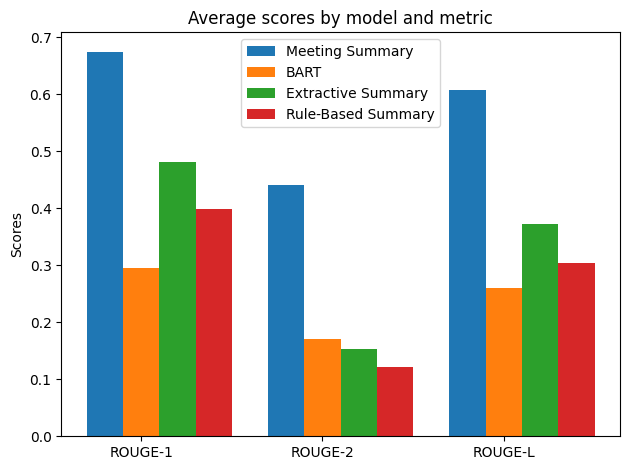

In [17]:
compute_summaries_and_rouge(shortest_dialogues, summarizer1, summarizer2, scorer)

### Longest

Dialogue 1
Original Dialogue:
Noah: Hi there! The quince we talked about the other day... Are you still interested?
Sophie: Hello Noah, but of course I am.Thank you.
Noah: Actually William went to collect the rest of them for you immediately. They're in a basket on our terrace, so you call collect them any time.
Sophie: That's very very kind of him! He's really a darling.
Sophie: We won't be going your direction any time soon I'm afraid. How long will they keep? Is it windfall?
Noah: Both really but they all look very healthy. No bruises afa one can see. Or only odd small ones. They' be alright for a couple of days I guess. The weather's cool.
Sophie: It would be a shame if they rotted. I'll talk to Frank and maybe to the twins too and go back to you asap.
Noah: OK.
Sophie: Hey Noah, the twins will be on their way from Notts tomorrow afternoon and passing Windfield. Is it alright if they pop in and collect the quince?
Noah: Absolutely! In fact anyone can come any time and just take the

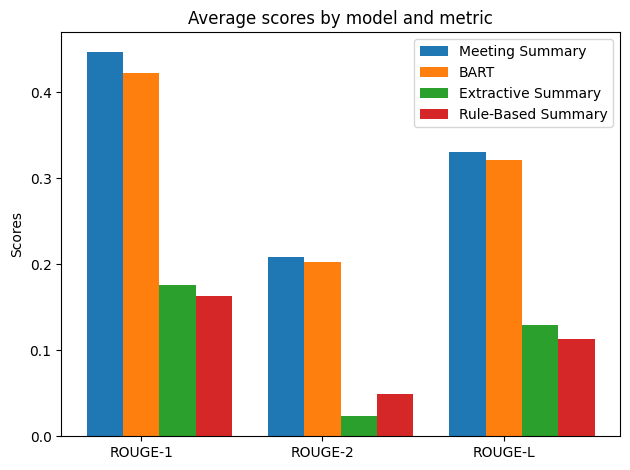

In [18]:
compute_summaries_and_rouge(longest_dialogues, summarizer1, summarizer2, scorer)

### Random

Your max_length is set to 62, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Dialogue 1


Your max_length is set to 142, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Louis: Gotta go, my mom's calling me
Fabian: Ok, see ya
Louis: See ya
Reference Summary:
Louis finishes the conversation with Fabian because his mother is calling.
Meeting Summary summary:
Louis' mom is calling him, so he has to leave.
BART summary:
Fabian and Louis will see each other soon. Louis has to go because his mom is calling him.       -  -  Â   .   "Louis and Fabian" are going to meet soon, as Fabian's mother is calling Louis.
Extractive summary:
Louis: Gotta go, my mom's calling me Fabian: Ok, see ya 
Rule-Based summary:
Louis said Gotta go, my mom's calling me Fabian said Ok, see ya Louis said See ya

Dialogue 2


Your max_length is set to 142, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Original Dialogue:
Max: I know I will never be famous music producer
Max: But check this out
Max: My latest project
Max: <file_other>
Jim: I'll listen to it when I get home.
Jim: Knowing you I'm sure it's good.
Max: Thanks
Max: Let me know what you think later
Jim: I will
Reference Summary:
Jim will check out Max's latest music project when he gets home.
Meeting Summary summary:
Max has sent Jim his latest music project. Jim will listen to it when he gets home.
BART summary:
Max sends Jim his latest music project. Jim will listen to it when he gets home and let him know what he thinks later.   He is sure it will be good, like Max's previous projects. He will share it with Max later. He is a music producer.
Extractive summary:
Max: I know I will never be famous music producer Max: <file_other> Jim: I'll listen to it when I get home. Jim: Knowing you I'm sure it's good. Max: Thanks 
Rule-Based summary:
Max said I know I will never be famous music producer Max said But check this out Max 

Your max_length is set to 62, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Leticia: would any of you have 10$ and could lend it? I'm really in need, I will gve it back as soon as possible
Lora: sure
Lora: is everything ok?
Leticia: actually no...
Leticia: I've lost my wallet, or someone stole it...i'm not sure but i always take care of my stuff so that's even more weird
Miranda: shit...that's bad
Miranda: if you need any help I'm also here
Leticia: thank you girls, really
Lora: you better call the bank and block your account
Leticia: I've already done it
Miranda: did you have like a lot of money in this wallet?
Leticia: fortunately not...you know i hate dealing with cash
Lora: at least that...
Leticia: yeah...but i'm afraid i'll have to get new documents and i have no time for that :///////////
Miranda: don't worry, maybe there will be some good person who posts it on lost/found
Leticia: I hope so
Reference Summary:
Leticia lost her wallet with cards and documents and needs to borrow 10 dollars. Miranda and Lora offer help. The girls hope s

Your max_length is set to 142, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Original Dialogue:
Jenny: where does Mary live now?
Maria: In Southampton 
Louis: Yes, she moved there in December
Reference Summary:
Mary moved to Southampton in December.
Meeting Summary summary:
Mary moved to Southampton in December.
BART summary:
Mary moved to Southampton in December. She lives with Louis and Maria. Jenny and Louis don't know where Mary lives.       in Southampton, according to Maria and Louis, and Jenny doesn't know either. She moved there from New York. 
Extractive summary:
Jenny: where does Mary live now? Maria: In Southampton Louis: Yes, she moved there in December 
Rule-Based summary:
Jenny said where does Mary live now Maria said In Southampton Louis said Yes, she moved there in December

Dialogue 5


Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 62, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Chandler: Phoebe!! Do you have money?? 
Phoebe: Yes I have .. But why do you need it..
Chandler: Open your door.. And pay the delivery guy standing outside my door..
Phoebe: Oh chandler !! you idiot... On my way..
Reference Summary:
Chandler asks Phoebe to open the door and pay the delivery guy standing outside his door.
Meeting Summary summary:
Phoebe will open Chandler's door and pay the delivery guy.
BART summary:
Phoebe has money. Chandler wants her to open her door and pay the delivery guy standing outside. Phoebe is on her way to do that. She doesn't understand why Chandler thinks she needs the money. She's angry with him.  
Extractive summary:
Phoebe: Oh chandler !! you idiot... On my way.. 
Rule-Based summary:
Do you have money Phoebe said Yes I have But why do you need it And pay the delivery guy standing outside my door

Dialogue 6


Your max_length is set to 142, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Ewan: Uncle I graduated!
Uncle Jayson: My nephew gradumacated! 
Uncle Jayson: How time flies congrats!
Ewan: Haha thanks! Gradiated! 😂
Uncle Jayson: 😂
Reference Summary:
Uncle Jayson is pleased with Ewan's graduation.
Meeting Summary summary:
Ewan graduated. Uncle Jayson congratulates him.
BART summary:
Ewan graduated. Uncle Jayson congratulates him on his nephew's graduation. Ewan finds the congratulations funny.       in response to the message from Uncle Jayson. Â   - ewan's uncle finds it funny too.
Extractive summary:
Uncle Jayson: My nephew gradumacated! Uncle Jayson: 😂 
Rule-Based summary:
Ewan said Uncle I graduated Uncle Jayson said My nephew gradumacated Uncle Jayson said How time flies congrats

Dialogue 7
Original Dialogue:
Mike: How did Chicago do last nite?
Pat: Chicago what?
Mike: Fire man!
Pat: dunno.
Mike: How come?
Pat: Its soccer right?
Mike: you not a soccer fan?
Pat: nah. baseball and hockey is wot i luv.
Mike: it's bears and white sox right?
Pat

Your max_length is set to 62, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Original Dialogue:
Rachel: <file_other>
Rachel: Top 50 Best Films of 2018
Rachel: :)
Janice: Omg, I've watched almost all 50... xDD
Spencer: Hahah, Deadpool 2 also??
Janice: Yep
Spencer: Really??
Janice: My bf forced me to watch it xD
Rachel: Hahah
Janice: It wasn't that bad
Janice: I thought it'd be worse
Rachel: And Avengers? :D
Janice: 2 times
Rachel: Omg
Janice: xP
Rachel: You are the best gf in the world
Rachel: Your bf should appreciate that ;-)
Janice: He does
Janice: x)
Reference Summary:
Rachel sends a list of Top 50 films of 2018. Janice watched almost half of them, Deadpool 2 and Avengers included.
Meeting Summary summary:
Janice watched Deadpool 2 and Avengers 2 twice because her boyfriend forced her to.
BART summary:
Rachel has sent Janice a list of the Top 50 Best Films of 2018. Janice has watched almost all of them. She has watched Deadpool 2 twice and Avengers twice. Her boyfriend forced her to watch both of them, but she didn't find them that bad.
Extractive summary:
R

Your max_length is set to 142, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Original Dialogue:
Marika: Are you coming today?
Lara: Yes!
Marika: Great!
Reference Summary:
Marika is coming today.
Meeting Summary summary:
Lara is coming to Marika today.
BART summary:
Lara is coming today. Marika is happy for her and is looking forward to her arrival.    Lara will see Marika today. She will arrive at Marika's place at 10:30.     lara will be there. 
Extractive summary:
Marika: Are you coming today? Lara: Yes! 
Rule-Based summary:
Marika said Are you coming today Lara said Yes Marika said Great

Dialogue 10
Original Dialogue:
Gary: Hey, don't forget about Tom's bday party!
Lara: I won't! What time should I show up?
Gary: Around 5 pm. He's supposed to be back home at 5:30, so we'll have just enough time to prep things up.
Lara: You're such a great boyfriend. He will be so happy!
Gary: Yep, I am :)
Lara: So I'll just pick up the cake and get the balloons...
Gary: Thanks, you're so helpful. I've already paid for the cake.
Lara: No problem, see you at 5 pm!
Gary: See y

Your max_length is set to 142, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)
Your max_length is set to 62, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Original Dialogue:
Joseph: It's fuzzy but I think you can recognize what's that(^_-)-☆
Joseph: <file_photo>
Ella: Ooooo
Ella: Baby cows??(/◕ヮ◕)/(/◕ヮ◕)/(/◕ヮ◕)/
Joseph: Wujek Janek has tween cows:D
Ella: Twins* darling xD
Joseph: Oh yeah, sorry Twins*
Ella: Good for him!! So cool❤️❤️
Ella: Wanna touch them❤️❤️❤️
Reference Summary:
Joseph has sent Ella a photo of Wujek Janek's twin baby cows. Ella is delighted.
Meeting Summary summary:
Joseph sends Ella a picture of newborn cows. 
BART summary:
Joseph sends Ella a photo of baby cows. Joseph's friend Wujek Janek has a pair of tween cows. Ella thinks it's cool and wants to touch them. Joseph doesn't want to touch the cows, but agrees to show them to Ella.
Extractive summary:
Joseph: It's fuzzy but I think you can recognize what's that(^_-)-☆ Joseph: <file_photo> Ella: Baby cows??(/◕ヮ◕)/(/◕ヮ◕)/(/◕ヮ◕)/ Joseph: Wujek Janek has tween cows:D Joseph: Oh yeah, sorry Twins* Ella: Good for him!! So cool❤️❤️ 
Rule-Based summary:
Joseph said It's fuzz

Your max_length is set to 142, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Original Dialogue:
Sue: can you pick the car up after work tomorrow please
James: yes and pay?
Sue: yes I will transfer the money in 
James: ok x
Reference Summary:
James will pick up the car after his work tomorrow. Sue already have sent him money. 
Meeting Summary summary:
James will pick up Sue's car after work tomorrow and pay for it.
BART summary:
James will pick up Sue's car tomorrow and pay for it. Sue will transfer the money in to him to pay for the car. He will pick the car up after work tomorrow and he will pick it up tomorrow evening.   Â   
Extractive summary:
Sue: can you pick the car up after work tomorrow please James: yes and pay? James: ok x 
Rule-Based summary:
Sue said can you pick the car up after work tomorrow please James said yes and pay Sue said yes I will transfer the money in James said ok x

Dialogue 18


Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Original Dialogue:
Chris: Oh, and we pushed some girls into the pool :)
June: That's not nice!
Chris: Depends how u look at it ;)
June: How come?
Chris: Well, we got them to undress, 'cause they were soaking wet :)
June: Ur awful!
Reference Summary:
Some girls had to undress because they had been pushed into the pool.
Meeting Summary summary:
Chris pushed some girls into the pool. He got them to undress.
BART summary:
Chris pushed some girls into the pool because they were soaking wet. He got them to undress. June thinks he's awful for pushing them into the swimming pool.    June doesn't agree with Chris' actions, but doesn't think he's a bad person.
Extractive summary:
Chris: Oh, and we pushed some girls into the pool :) June: That's not nice! June: How come? 
Rule-Based summary:
Chris said Oh, and we pushed some girls into the pool  said) June said That's not nice Chris said Depends how u look at it ;) June said How come Chris said Well, we got them to undress, 'cause they were soaki

Your max_length is set to 62, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Rudi: Hetta, did you see the last trump video
Henrietta: nope
Henrietta: what did he do now?
Rudi: <file_video>
Henrietta: OMG
Henrietta: what a jerk
Rudi: it gets worse
Rudi: <file_other>
Rudi: the whole interview is here
Henrietta: can't believe he said that about a congress woman
Rudi: yeah
Henrietta: do you wonder where the limit is?
Rudi: wdym
Henrietta: if he will say something that will actually get him kicked out of the white house
Rudi: not really
Henrietta: fuck
Rudi: yeah
Reference Summary:
Trump is acting like a contemptible fool and it is getting worse. Rudi has sent Henrietta the link to his interview.
Meeting Summary summary:
Rudi and Henrietta are shocked by what Donald Trump said about a congresswoman.
BART summary:
Rudi and Henrietta are shocked by Donald Trump's comments about congresswoman. They wonder if he will be kicked out of the White House soon.       - Henrietta and Rudi are wondering where the limit is for what a politician can say. 
Extra

Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Ally: how many did you do so far?
Jill: like 20 or 30
Jill: I can't do more than 3-4 per day
Ally: how many hours?
Jill: 40? maybe 35...
Ally: ok, same here
Reference Summary:
Jill did 20 or 30 so far, 3-4 per day, 40 or 35 hours, so the same as Ally.
Meeting Summary summary:
Jill can't do more than 3-4 hours of work per day. Ally and Jill can only do about 20-30 hours each.
BART summary:
Jill can't do more than 3-4 hours of work per day. Ally and Jill can't work more than 40 hours per day, so far they have done about 20-30 hours each.    - Ally and Jill are going to work together. 
Extractive summary:
Ally: how many did you do so far? Jill: I can't do more than 3-4 per day Jill: 40? maybe 35... Ally: ok, same here 
Rule-Based summary:
Ally said how many did you do so far Jill said like 20 or 30 Jill said I can't do more than 3-4 per day Ally said how many hours Ally said ok, same here

Average ROUGE-1 F1 score for Meeting Summary: 0.5548502966768134
Average ROUGE-1 

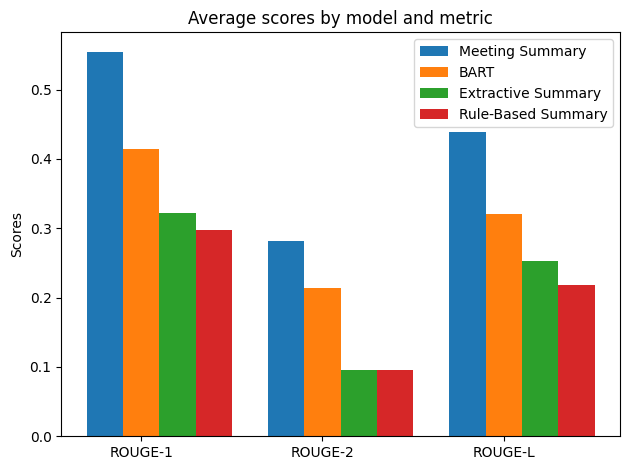

In [19]:
compute_summaries_and_rouge(random_dialogues, summarizer1, summarizer2, scorer)

### Contradictions

Your max_length is set to 62, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Dialogue 1


Your max_length is set to 142, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 62, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Original Dialogue:
Ann: Movies at 5?
Mary: I can't, 6?
Ann: Maybe next time?
Mary: Actually nvm, 5 works.
Ann: Ok, see you.
Reference Summary:
Ann and Mary decide to go to the movies at 5.
Meeting Summary summary:
Ann and Mary are going to the movies at 5.
BART summary:
Mary and Ann are going to see a movie at 5. Mary can't make it at 6, so they'll go to the cinema at 5 as it's the earliest option.    - Ann and Mary will see each other at 5 o'clock. 
Extractive summary:
Ann: Movies at 5? Mary: I can't, 6? Mary: Actually nvm, 5 works. Ann: Ok, see you. 
Rule-Based summary:
Ann said Movies at 5 Mary said I can't, 6 Mary said Actually nvm, 5 works

Dialogue 2


Your max_length is set to 142, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 62, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Original Dialogue:
John: Hey, want to grab lunch?
Emily: Sure, where?
John: How about the new cafe?
Emily: Sounds good. 1 PM?
John: Perfect. See you then.
Reference Summary:
John and Emily plan to have lunch at the new cafe at 1 PM.
Meeting Summary summary:
John and Emily will have lunch together at the new cafe at 1 PM.
BART summary:
John and Emily are going to the new cafe for lunch at 1 PM. They will meet at the cafe to have lunch with John.    .      - John and Emily will see each other there.  - Emily will pick the place. 
Extractive summary:
Emily: Sure, where? John: How about the new cafe? Emily: Sounds good. 1 PM? 
Rule-Based summary:
John said Hey, want to grab lunch Emily said Sure, where John said How about the new cafe

Dialogue 3


Your max_length is set to 142, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 62, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Original Dialogue:
Tom: Did you finish the report?
Jerry: Not yet, still working on it.
Tom: When do you think it'll be done?
Jerry: By tomorrow morning.
Tom: Great, thanks.
Reference Summary:
Jerry tells Tom the report will be done by tomorrow morning.
Meeting Summary summary:
Jerry will finish the report by tomorrow morning.
BART summary:
Jerry hasn't finished the report yet, but he should have it done by tomorrow morning. Tom hopes it will be good.    Tom and Jerry will meet tomorrow morning to discuss the report. Tom is very happy about it and wishes Jerry good luck. 
Extractive summary:
Tom: Did you finish the report? Jerry: Not yet, still working on it. Tom: When do you think it'll be done? Jerry: By tomorrow morning. Tom: Great, thanks. 
Rule-Based summary:
Tom said Did you finish the report Jerry said Not yet, still working on it Tom said When do you think it'll be done

Dialogue 4


Your max_length is set to 142, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 62, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Original Dialogue:
Sarah: Can you pick up some milk?
Mark: Sure, anything else?
Sarah: Bread and eggs too.
Mark: Got it.
Reference Summary:
Sarah asks Mark to pick up milk, bread, and eggs.
Meeting Summary summary:
Mark will buy milk, bread and eggs on Sarah's request.
BART summary:
Mark will buy milk, bread and eggs for Sarah and some snacks for himself and Sarah. He will pick up the milk and bread on Sarah's request. He'll also get some eggs and some eggs for himself. He's already got the bread and the eggs. 
Extractive summary:
Sarah: Can you pick up some milk? Mark: Sure, anything else? Sarah: Bread and eggs too. Mark: Got it. 
Rule-Based summary:
Sarah said Can you pick up some milk Mark said Sure, anything else Sarah said Bread and eggs too

Dialogue 5


Your max_length is set to 142, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Original Dialogue:
Lisa: Are you coming to the party?
Megan: I might be late.
Lisa: No worries, just come when you can.
Megan: Will do, thanks!
Reference Summary:
Megan tells Lisa she might be late to the party but will come.
Meeting Summary summary:
Megan might be late to the party.
BART summary:
Megan might be late to the party. Lisa will let her know if she can come when she can, as long as she's available.   Lisa will see Megan at the party when she's ready. Lisa and Megan will see each other later. 
Extractive summary:
Lisa: Are you coming to the party? Megan: I might be late. Lisa: No worries, just come when you can. Megan: Will do, thanks! 
Rule-Based summary:
Lisa said Are you coming to the party Megan said I might be late Lisa said No worries, just come when you can

Dialogue 6
Original Dialogue:
Jake: We need to brainstorm ideas for the new marketing campaign.
Laura: Let’s think outside the box this time.
Michael: How about a social media challenge?
Jake: Interesting. What ki

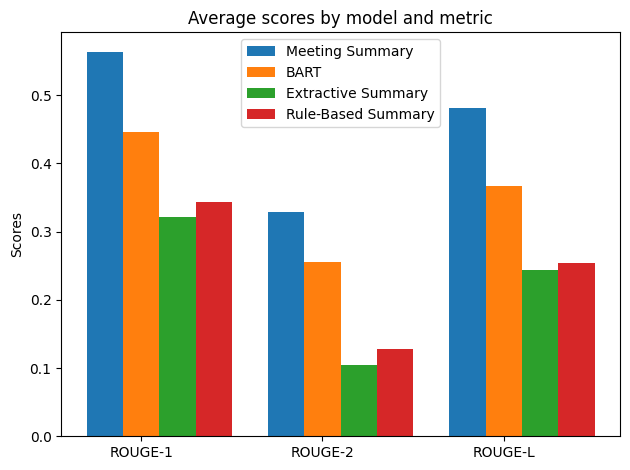

In [20]:
compute_summaries_and_rouge(contradictions_dialogues, summarizer1, summarizer2, scorer)

### Many speakers

Dialogue 1
Original Dialogue:
Dan: Guys, so are we going out on Sat?
Tim: I'm ready when you are
Chris: I'm OK too, in the centre right?
Tom: I'm out guys sorry. 
Dan: come on Tom, what's wring this time
Tom: told ya before. party at in-laws
Chris: always the same story right
Martin: right guys, so what time?
Tim: start @8? finish. 8 if we're lucky
Dan: yeah, i need to be home at 2 and ready to drive on Sunday noon
Chris: so you takin it easy this time
Martin: i guess i'd have to as well
Tim: guys you sound like 60 yos
Chris: Tim, are the last two standing or what?
Tim: i gather
Dan: you two will also grow up one day. 
Reference Summary:
Dan,Tim, Chris and Martin will meet at 8. Dan and Martin will take it easy this time. Tom can't make it as he has a party at in-laws.
Meeting Summary summary:
Dan, Tim, Chris and Martin are going out on Saturday at 8 pm. Tom can't make it due to a party at his in-laws.
BART summary:
Dan, Tim, Chris and Martin are going out on Saturday at 8. Dan needs t

Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Original Dialogue:
Natalie: Well well weeeeeell, I see somethings going on here at last
Martin: (Y)
Adam: any confirmed data?
Anna: Hello everyone!!! Id love to invite everybody to my bday. I would be extremaly happy if you could come 6th of November at 1930
Martin: <3
Margot: <3
Mia: (Y)
Reference Summary:
Anna organises a birthday's party on the 6th of November at 19:30.
Meeting Summary summary:
Anna invites everyone for her birthday on 6th of November at 1930.
BART summary:
Anna invites everyone to her birthday party on 6th of November at 1930. Natalie, Martin, Margot, Mia and Adam will come.       - Natalie, Anna, Martin and Margot will come to Anna's birthday party. 
Extractive summary:
Natalie: Well well weeeeeell, I see somethings going on here at last Martin: (Y) Adam: any confirmed data? Anna: Hello everyone!!! Id love to invite everybody to my bday. I would be extremaly happy if you could come 6th of November at 1930 Martin: <3 
Rule-Based summary:
Natalie said Well well weee

Your max_length is set to 142, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Original Dialogue:
Holt: ladies, an important question. what to get my sis for bday?
Darla: how old?
Holt: 21
Olive: can't be too personal
Treena: cosmetics maybe?
Zula: i'd get her DVDs or book series. always works
Holt: you might be right. set of DVDs and some cosmetics?
Olive: we'd all be happy i guess if you know what she likes
Reference Summary:
Holt asks his girlfriends some advice on a present for his sister on her 21st birthday. Treena recommends cosmetics, whereas Zula suggests DVDs or book series. 
Meeting Summary summary:
Holt's sister is 21. She will get a set of DVDs and cosmetics for her birthday.
BART summary:
Holt's sister is 21. He will get her a set of DVDs and cosmetics for her birthday. Darla, Olive, Treena, Zula and Zula agree that she should get her DVDs or book series.    .  
Extractive summary:
Holt: ladies, an important question. what to get my sis for bday? Darla: how old? Holt: 21 Olive: can't be too personal Treena: cosmetics maybe? Zula: i'd get her DVDs or

Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Original Dialogue:
Natalie: Well well weeeeeell, I see somethings going on here at last
Martin: (Y)
Adam: any confirmed data?
Anna: Hello everyone!!! Id love to invite everybody to my bday. I would be extremaly happy if you could come 6th of November at 1930
Martin: <3
Margot: <3
Mia: (Y)
Reference Summary:
Anna organises a birthday's party on the 6th of November at 19:30.
Meeting Summary summary:
Anna invites everyone for her birthday on 6th of November at 1930.
BART summary:
Anna invites everyone to her birthday party on 6th of November at 1930. Natalie, Martin, Margot, Mia and Adam will come.       - Natalie, Anna, Martin and Margot will come to Anna's birthday party. 
Extractive summary:
Natalie: Well well weeeeeell, I see somethings going on here at last Martin: (Y) Adam: any confirmed data? Anna: Hello everyone!!! Id love to invite everybody to my bday. I would be extremaly happy if you could come 6th of November at 1930 Martin: <3 
Rule-Based summary:
Natalie said Well well weee

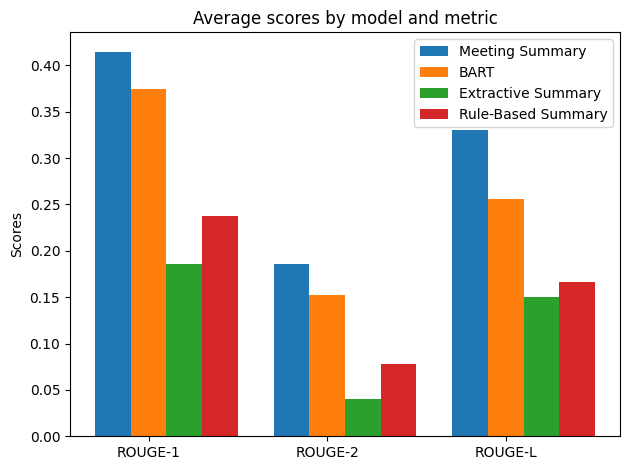

In [22]:
compute_summaries_and_rouge(multi_speaker_dialogues, summarizer1, summarizer2, scorer)

### Single speaker

Your max_length is set to 62, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Dialogue 1


Your max_length is set to 142, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Original Dialogue:
Emily: I need to pick up some groceries after work. I'll get milk, bread, and eggs. Should I get anything else? Maybe some fruits and vegetables too. And perhaps some snacks for the weekend. Yes, that should be enough.
Reference Summary:
Emily plans her grocery shopping, deciding to get milk, bread, eggs, fruits, vegetables, and snacks.
Meeting Summary summary:
Emily will buy milk, bread, eggs, fruits and vegetables and snacks for the weekend after work.
BART summary:
Emily will buy milk, bread, eggs, vegetables, fruits and vegetables, and snacks for the weekend after work. She will also get some groceries for her and her family at the weekend. She should get enough food for a whole week. She'll get groceries after work as well. 
Extractive summary:
Emily: I need to pick up some groceries after work. I'll get milk, bread, and eggs. Should I get anything else? Maybe some fruits and vegetables too. And perhaps some snacks for the weekend. Yes, that should be enough. 
R

Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Original Dialogue:
John: I have a busy day today. First, I have a meeting at 9 AM. Then, I need to finish the report by noon. After lunch, I have a conference call at 2 PM. In the evening, I’ll go to the gym. Busy but productive day ahead.
Reference Summary:
John outlines his busy day with meetings, report work, a conference call, and a gym session.
Meeting Summary summary:
John has a busy day ahead. He has a meeting at 9 AM, a conference call at 2 PM and a report to finish by noon. In the evening, he will go to the gym.
BART summary:
John has a busy day today. He has a meeting at 9 AM, a report at noon and a conference call at 2 PM. In the evening, he will go to the gym. He will finish the report by noon and then work on the conference call.
Extractive summary:
John: I have a busy day today. First, I have a meeting at 9 AM. Then, I need to finish the report by noon. After lunch, I have a conference call at 2 PM. In the evening, I’ll go to the gym. Busy but productive day ahead. 
Rule-

Your max_length is set to 142, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 62, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Original Dialogue:
Anna: I need to clean the house this weekend. I’ll start with the living room. Then, I'll move to the kitchen. After that, the bedrooms need a good vacuuming. Lastly, I'll clean the bathrooms. It’s going to be a lot of work, but it’ll be worth it.
Reference Summary:
Anna plans her weekend house cleaning, starting with the living room, then the kitchen, bedrooms, and bathrooms.
Meeting Summary summary:
Anna needs to clean the house this weekend. She will start with the living room, then the kitchen, the bedrooms and the bathrooms.
BART summary:
Anna needs to clean the house this weekend. She will start with the living room, move to the kitchen, then the bedrooms and the bathrooms. It's going to be a lot of work, but it will be worth it, she says.   
Extractive summary:
Anna: I need to clean the house this weekend. I’ll start with the living room. Then, I'll move to the kitchen. After that, the bedrooms need a good vacuuming. Lastly, I'll clean the bathrooms. It’s goin

Your max_length is set to 142, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Original Dialogue:
Tom: I should call my parents today. I haven't talked to them in a while. I'll ask them how they're doing. Maybe I'll invite them over for dinner this weekend. It’ll be nice to catch up with them.
Reference Summary:
Tom decides to call his parents, ask about their well-being, and possibly invite them over for dinner.
Meeting Summary summary:
Tom will call his parents today to ask them how they're doing and maybe invite them for dinner this weekend.
BART summary:
Tom will call his parents today to ask them how they're doing. He might invite them over for dinner this weekend, as he hasn't talked to them in a while.    Tom wants to catch up with them and ask them about their lives. 
Extractive summary:
Tom: I should call my parents today. I haven't talked to them in a while. I'll ask them how they're doing. Maybe I'll invite them over for dinner this weekend. It’ll be nice to catch up with them. 
Rule-Based summary:
Tom said I should call my parents today I haven't talk

Your max_length is set to 142, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Original Dialogue:
Laura: I need to finish reading this book by the end of the week. I’m halfway through, so I need to read at least 50 pages a day. It’s a really interesting book, so it shouldn’t be too hard. I’ll make sure to find some quiet time each day to read.
Reference Summary:
Laura plans to finish her book by reading at least 50 pages a day.
Meeting Summary summary:
Laura needs to read at least 50 pages a day to finish the book by the end of the week.
BART summary:
Laura needs to finish reading a book by the end of the week. She needs to read at least 50 pages a day. Laura will make sure to find some quiet time each day to read. Laura is halfway through the book. It's a really interesting book.
Extractive summary:
Laura: I need to finish reading this book by the end of the week. I’m halfway through, so I need to read at least 50 pages a day. It’s a really interesting book, so it shouldn’t be too hard. I’ll make sure to find some quiet time each day to read. 
Rule-Based summary

Your max_length is set to 142, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Original Dialogue:
Mike: I should start running again. It’s been months since I last ran. I’ll start with a short run, maybe 2 miles. Gradually, I’ll increase the distance. Running in the morning would be best, before work. Yes, I’ll start tomorrow.
Reference Summary:
Mike plans to resume running, starting with 2 miles and gradually increasing the distance, running in the mornings.
Meeting Summary summary:
Mike will start running again tomorrow morning before work. He will start with a short 2-mile run.
BART summary:
Mike will start running again tomorrow. He will start with a short 2-mile run and gradually increase the distance. He wants to do it in the morning before work. It's been months since he last ran.       .  
Extractive summary:
Mike: I should start running again. It’s been months since I last ran. I’ll start with a short run, maybe 2 miles. Gradually, I’ll increase the distance. Running in the morning would be best, before work. Yes, I’ll start tomorrow. 
Rule-Based summary

Your max_length is set to 142, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 62, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Sophie: I need to plan my vacation. I want to go somewhere warm, maybe a beach destination. I’ll look for flights to the Caribbean. I should also book a hotel. A place with good reviews and close to the beach would be ideal. I’m so excited!
Reference Summary:
Sophie plans her vacation, looking for flights and hotels in a warm beach destination, possibly the Caribbean.
Meeting Summary summary:
Sophie wants to go to the Caribbean. Sophie will look for flights and book a hotel.
BART summary:
Sophie wants to go somewhere warm. She will look for flights to the Caribbean and book a hotel with good reviews close to the beach. She is so excited.    .   i   in the Caribbean.  In the Caribbean, Sophie would like to go to a beach destination. 
Extractive summary:
Sophie: I need to plan my vacation. I want to go somewhere warm, maybe a beach destination. I’ll look for flights to the Caribbean. I should also book a hotel. A place with good reviews and close to the beach would be 

Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Original Dialogue:
Alex: I need to fix my car this weekend. The brakes have been making a weird noise. I’ll take it to the mechanic first thing Saturday morning. Hopefully, it’s nothing too serious. I should also get the oil changed while I’m there.
Reference Summary:
Alex plans to take his car to the mechanic to fix the brakes and get the oil changed.
Meeting Summary summary:
Alex's car brakes have been making a weird noise, so he will take it to the mechanic on Saturday morning.
BART summary:
Alex will take his car to the mechanic on Saturday morning. The brakes have been making a weird noise. Alex should also get the oil changed while he's there.    .   i   in the car this weekend.  In the car it's nothing too serious.
Extractive summary:
Alex: I need to fix my car this weekend. The brakes have been making a weird noise. I’ll take it to the mechanic first thing Saturday morning. Hopefully, it’s nothing too serious. I should also get the oil changed while I’m there. 
Rule-Based summa

Your max_length is set to 142, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Original Dialogue:
Rachel: I should organize my closet. There are so many clothes I don’t wear anymore. I’ll start by sorting everything into keep, donate, and toss piles. It’ll be a big project, but I’ll feel so much better once it’s done.
Reference Summary:
Rachel plans to organize her closet by sorting clothes into keep, donate, and toss piles.
Meeting Summary summary:
Rachel will sort through her clothes and sort them into keep, donate, and toss piles.
BART summary:
Rachel is going to organize her closet and sort her clothes into keep, donate, and toss piles. She will feel better when she's done.       - Rachel's closet is full of clothes that she doesn't wear anymore and she needs to sort them. 
Extractive summary:
Rachel: I should organize my closet. There are so many clothes I don’t wear anymore. I’ll start by sorting everything into keep, donate, and toss piles. It’ll be a big project, but I’ll feel so much better once it’s done. 
Rule-Based summary:
There are so many clothes I

Your max_length is set to 142, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Original Dialogue:
Kevin: I need to start eating healthier. I’ll begin by cutting out junk food. I’ll also add more fruits and vegetables to my diet. Maybe I should start cooking more meals at home too. It’s going to be a big change, but it’s necessary.
Reference Summary:
Kevin decides to eat healthier by cutting out junk food, adding more fruits and vegetables, and cooking more meals at home.
Meeting Summary summary:
Kevin wants to start eating healthier. He will cut out junk food and add more fruits and vegetables to his diet. Kevin will start cooking more at home.
BART summary:
Kevin will start cutting out junk food and adding more fruits and vegetables to his diet. He will also start cooking more meals at home. It's going to be a big change, but it's necessary for Kevin's health and he needs to start eating healthier.
Extractive summary:
Kevin: I need to start eating healthier. I’ll begin by cutting out junk food. I’ll also add more fruits and vegetables to my diet. Maybe I should 

Your max_length is set to 142, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Original Dialogue:
Sarah: I need to catch up on my emails. There are so many unread messages. I’ll start with the most urgent ones. Then, I’ll go through the rest. I should also unsubscribe from newsletters I never read. That’ll help reduce the clutter. Maybe I can set aside some time every day to keep my inbox organized. It’s so easy to fall behind.
Reference Summary:
Sarah plans to catch up on her emails, starting with urgent ones and unsubscribing from unnecessary newsletters, and considers setting aside daily time for this.
Meeting Summary summary:
Sarah needs to catch up on her emails. She will start with the most urgent ones and unsubscribe from the rest.
BART summary:
Sarah needs to catch up on her emails. She should unsubscribe from some of the newsletters she doesn't read. She needs to set aside some time every day to keep her inbox organized, as it's so easy to fall behind. Sarah will start with the most urgent messages and go through the rest.
Extractive summary:
Sarah: I ne

Your max_length is set to 142, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Original Dialogue:
Chris: I should start learning a new language. Spanish would be useful. I’ll look for an online course. Maybe I can practice with a language partner too. It’ll be a fun and rewarding challenge. I’ve always wanted to visit Spain and South America. Being able to speak the language would make the trips even more enjoyable. Yes, I’ll start today.
Reference Summary:
Chris decides to start learning Spanish, looking for an online course and considering practicing with a language partner, motivated by travel aspirations.
Meeting Summary summary:
Chris will start learning Spanish today. He wants to visit Spain and South America.
BART summary:
Chris will start learning Spanish today. He will look for an online course and practice with a language partner. Chris has always wanted to visit Spain and South America and wants to be able to speak the language. He thinks that learning Spanish would make the trips even more enjoyable.
Extractive summary:
Chris: I should start learning 

Your max_length is set to 142, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Original Dialogue:
Megan: I need to find a new hobby. Something creative like painting or photography. I’ll look for local classes. It’ll be a nice way to relax and unwind. Plus, I’ll meet new people with similar interests. It’s been a while since I did something just for fun. Maybe I’ll start with a weekend workshop and see how it goes. Yes, that sounds perfect.
Reference Summary:
Megan decides to find a new hobby, considering painting or photography, and plans to look for local classes and workshops.
Meeting Summary summary:
Megan wants to start painting or photography as a hobby. She will look for local classes.
BART summary:
Megan is looking for a new hobby. She wants to start with a weekend workshop and see how it goes. She will look for local classes and meet new people with similar interests. Megan would like to do something creative like painting or photography. It's been a while since she did something just for fun.
Extractive summary:
Megan: I need to find a new hobby. Someth

Your max_length is set to 142, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Original Dialogue:
Daniel: I should start saving more money. I’ll create a budget to track my expenses. Maybe I can cut down on dining out. I’ll also set up a savings account. It’s important to be more financially responsible. I could start by setting small, achievable goals. Maybe save a certain amount each month and gradually increase it. Financial stability is crucial.
Reference Summary:
Daniel plans to save more money by creating a budget, cutting down on dining out, setting up a savings account, and setting small financial goals.
Meeting Summary summary:
Daniel will create a budget to track his expenses and set up a savings account.
BART summary:
Daniel wants to start saving more money. He will create a budget and set up a savings account. He wants to save a certain amount each month and gradually increase it. Financial stability is crucial for Daniel's financial well-being and he should start by setting achievable goals.
Extractive summary:
Daniel: I should start saving more mone

Your max_length is set to 142, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Original Dialogue:
Olivia: I need to redecorate my living room. I’ll start by choosing a new color scheme. Maybe something bright and cheerful. I’ll look for some new furniture as well. A comfy couch and a stylish coffee table would be nice. I should also get some plants to add a touch of green. It’ll be a big project, but I’m excited to give the space a fresh look.
Reference Summary:
Olivia plans to redecorate her living room, choosing a new color scheme, buying new furniture, and adding plants for a fresh look.
Meeting Summary summary:
Olivia wants to redecorate her living room. She will choose a new color scheme and buy some new furniture. She should also buy some plants.
BART summary:
Olivia is going to redecorate her living room. She wants to choose a new color scheme and furniture. She will also get some plants to add a touch of green to the space. She is excited to give the space a fresh look. 
Extractive summary:
Olivia: I need to redecorate my living room. I’ll start by choosi

Your max_length is set to 142, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Original Dialogue:
Mark: I need to plan my week ahead. On Monday, I have a project meeting in the morning. Tuesday is my deadline for the quarterly report. Wednesday, I need to visit the client’s site. Thursday, there’s a team-building activity in the afternoon. Friday, I’ll catch up on any pending tasks. It’s going to be a hectic week, but planning ahead will help me stay on top of things.
Reference Summary:
Mark plans his busy week with a project meeting, report deadline, client visit, team-building activity, and catching up on tasks.
Meeting Summary summary:
Mark has a project meeting on Monday, a deadline for the quarterly report on Tuesday, a visit to the client's site on Wednesday and a team-building activity on Thursday. On Friday he will catch up on any pending tasks.
BART summary:
Mark has a busy week ahead. He has a project meeting on Monday, a deadline for the quarterly report on Tuesday, a team-building activity on Thursday and a catch-up on Friday. He needs to plan his wee

Your max_length is set to 142, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Original Dialogue:
Tina: I need to start a new workout routine. I’ll try to go to the gym at least three times a week. I’ll focus on cardio on Mondays, strength training on Wednesdays, and a mix of both on Fridays. I should also incorporate some yoga for flexibility. Keeping a workout log might help me stay motivated. It’s important to stay active and healthy.
Reference Summary:
Tina plans a new workout routine with gym sessions three times a week, focusing on cardio, strength training, and yoga.
Meeting Summary summary:
Tina will try to go to the gym at least three times a week. She will focus on cardio on Mondays, strength training on Wednesdays and yoga on Fridays.
BART summary:
Tina will try to go to the gym at least three times a week. She will focus on cardio on Mondays, strength training on Wednesdays and a mix of both on Fridays. She should also incorporate some yoga for flexibility. Tina will keep a workout log to stay motivated.
Extractive summary:
Tina: I need to start a new

Your max_length is set to 142, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Original Dialogue:
Nathan: I should start writing a journal. It might help me organize my thoughts better. I’ll start by writing a little every night before bed. Reflecting on my day and setting goals for tomorrow. It’s a good way to unwind and clear my mind. Maybe I can also jot down any creative ideas I have. This could be a really beneficial habit.
Reference Summary:
Nathan decides to start journaling every night to organize his thoughts, reflect on his day, and set goals.
Meeting Summary summary:
Nathan will start writing in a journal every night before bedtime.
BART summary:
Nathan will start writing in a journal every night before bedtime to organize his thoughts better. He hopes it will help him unwind and clear his mind. He also wants to jot down any creative ideas he might have.   nathan.com.
Extractive summary:
Nathan: I should start writing a journal. It might help me organize my thoughts better. I’ll start by writing a little every night before bed. Reflecting on my day and

Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Original Dialogue:
Lisa: I need to revamp my wardrobe. A lot of my clothes are outdated. I’ll start by sorting through what I have and deciding what to keep, donate, or throw away. Then, I’ll make a list of basics I need to buy. Maybe I’ll also add a few trendy pieces. Shopping can be fun if it’s planned out. Time for a fresh look!
Reference Summary:
Lisa plans to revamp her wardrobe by sorting old clothes, making a list of basics to buy, and adding some trendy pieces.
Meeting Summary summary:
Lisa needs to revamp her wardrobe. She will sort through what she has and decide what to keep, donate or throw away. Then she will make a list of basics and add a few trendy pieces.
BART summary:
Lisa needs to revamp her wardrobe. She will start by sorting through what she has and deciding what to keep, donate, or throw away. Then, she will make a list of basics she needs to buy and maybe add a few trendy pieces to her collection.
Extractive summary:
Lisa: I need to revamp my wardrobe. A lot of m

Your max_length is set to 142, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Original Dialogue:
James: I need to prepare for my presentation next week. I’ll start by outlining the key points I want to cover. Then, I’ll create some slides to highlight the main ideas. Practice will be crucial, so I’ll rehearse a few times. I should also anticipate potential questions and prepare answers. Confidence is key, so I need to make sure I’m well-prepared.
Reference Summary:
James plans to prepare for his presentation by outlining key points, creating slides, practicing, and preparing for potential questions.
Meeting Summary summary:
James needs to prepare for his presentation next week. He will create some slides to highlight the main ideas and rehearse a few times.
BART summary:
James needs to prepare for his presentation next week. He will create some slides to highlight the main ideas and rehearse a few times. Confidence is key, so he needs to make sure he's well-prepared. He should also anticipate potential questions and prepare answers.
Extractive summary:
James: I 

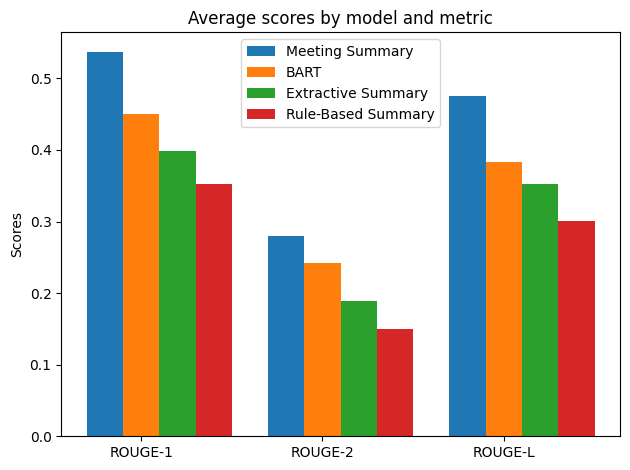

In [23]:
compute_summaries_and_rouge(single_speaker, summarizer1, summarizer2, scorer)